<a href="https://colab.research.google.com/github/sborah53/Machine-Learning-for-Physical-Sciences/blob/main/MLPS_Support_Vector_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machines (SVMs)

**This notebook was prepared by Sangkha Borah, IIT Hyderabad, in February 2026.**

In this toy model we represent two phases of matter as points in a two‑dimensional feature space spanned by an order parameter $\psi$ and temperature $T$. Ordered states (Phase A) correspond to low temperatures and nonzero $\psi$, while disordered states (Phase B) correspond to higher temperatures and $\psi \approx 0$, so the two phases form approximately linearly separable clusters in $(\psi, T)$ space. The goal is to learn a linear decision boundary that separates the two phases and is robust to noise, mimicking the task of locating a phase boundary in a phase diagram using supervised learning.

Support Vector Machines (SVMs) construct a linear classifier that maximizes the geometric margin between two classes, i.e. the distance from the decision boundary to the closest data points (the support vectors). For a linear SVM this corresponds to finding a hyperplane $w \cdot x + b = 0$ with minimal norm $\lVert w \rVert$, subject to constraints that label-consistent points lie on the correct side of the margin; this is the maximal‑margin classifier. In the soft‑margin setting, violations of the margin are penalized via the hinge loss
$$\max(0, 1 - y(w \cdot x + b)),$$ leading to the primal objective $$\frac{\lambda}{2}\lVert w \rVert^2 + \frac{1}{N}\sum_i \max(0, 1 - y_i(w \cdot x_i + b)).$$

In this notebook we first visualize the two phases in $(\psi, T)$ space, then train an SVM using scikit‑learn as a reference implementation, and finally implement the primal hinge‑loss optimization ourselves to make the maximum‑margin geometry and “energy minimization” analogy explicit.

In this toy problem we view two phases of matter (ordered vs disordered) as points in a 2D feature space spanned by an order parameter $\psi$ and temperature $T$. Ordered states correspond to nonzero $\psi$ at low $T$, while disordered states cluster near $\psi \approx 0$ at higher $T$, giving two approximately linearly separable “blobs” in $(\psi, T)$ space. Our goal is to learn a phase boundary that separates these two classes and is robust to noise, analogous to locating a transition line in a phase diagram.




## Physics

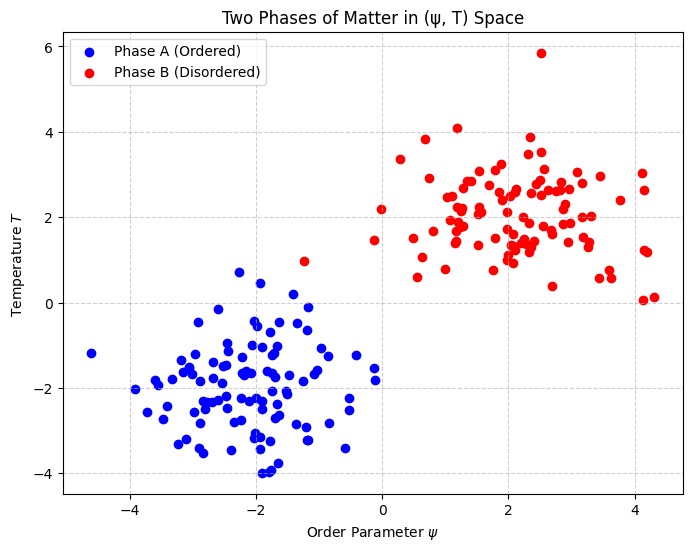

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_phase_data(n_samples=200):
    """
    Simulates data for two phases of matter based on Order Parameter (x1)
    and Temperature (x2).
    Phase A (Ordered): Low Temp, High/Low Order (Non-zero).
    Phase B (Disordered): High Temp, Low Order (Zero-ish).
    Simplified to linearly separable blobs for this demo.
    """
    np.random.seed(42)

    # Phase 1: "Ordered" (Blue) - centered at (-2, -2)
    X1 = np.random.randn(n_samples // 2, 2) + np.array([-2, -2])
    y1 = -1 * np.ones(n_samples // 2)

    # Phase 2: "Disordered" (Red) - centered at (2, 2)
    X2 = np.random.randn(n_samples // 2, 2) + np.array([2, 2])
    y2 = np.ones(n_samples // 2)

    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))
    return X, y

# ---- 1. Physics picture only ----
X, y = generate_phase_data()

plt.figure(figsize=(8, 6))
plt.scatter(X[y==-1][:,0], X[y==-1][:,1], color='blue', label='Phase A (Ordered)')
plt.scatter(X[y==1][:,0], X[y==1][:,1], color='red', label='Phase B (Disordered)')

plt.title("Two Phases of Matter in (ψ, T) Space")
plt.xlabel(r"Order Parameter $\psi$")
plt.ylabel(r"Temperature $T$")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Solve with scikit-learn SVM

sklearn SVM:
Weights w: [1.39484813 2.24130532]
Bias b: 0.5445727371976105


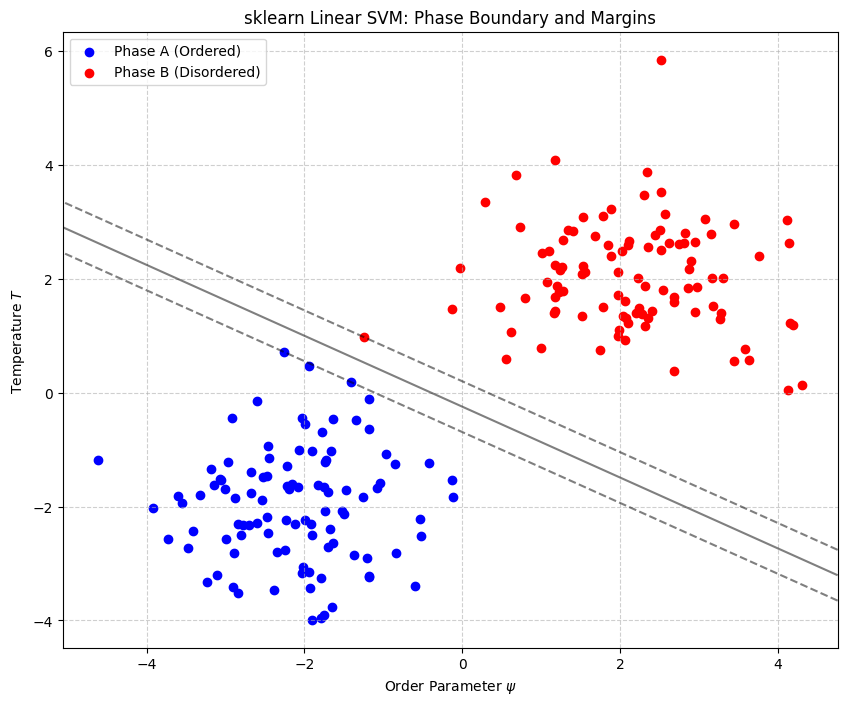

In [ ]:
from sklearn.svm import SVC

# ---- 2. SVM with scikit-learn ----
svm_sklearn = SVC(kernel='linear', C=100.0)  # large C ~ hard margin
svm_sklearn.fit(X, y)

w = svm_sklearn.coef_[0]
b = svm_sklearn.intercept_[0]
print("sklearn SVM:")
print("Weights w:", w)
print("Bias b:", b)

plt.figure(figsize=(10, 8))

# Plot data
plt.scatter(X[y==-1][:,0], X[y==-1][:,1], color='blue', label='Phase A (Ordered)')
plt.scatter(X[y==1][:,0], X[y==1][:,1], color='red', label='Phase B (Disordered)')

# Decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svm_sklearn.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1],
           alpha=0.5, linestyles=['--', '-', '--'])

plt.title("sklearn Linear SVM: Phase Boundary and Margins")
plt.xlabel(r"Order Parameter $\psi$")
plt.ylabel(r"Temperature $T$")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Custom primal SVM implementation

Custom SVM (primal GD):
Weights w: [0.68876784 0.69856541]
Bias b: 0.01245000000000077


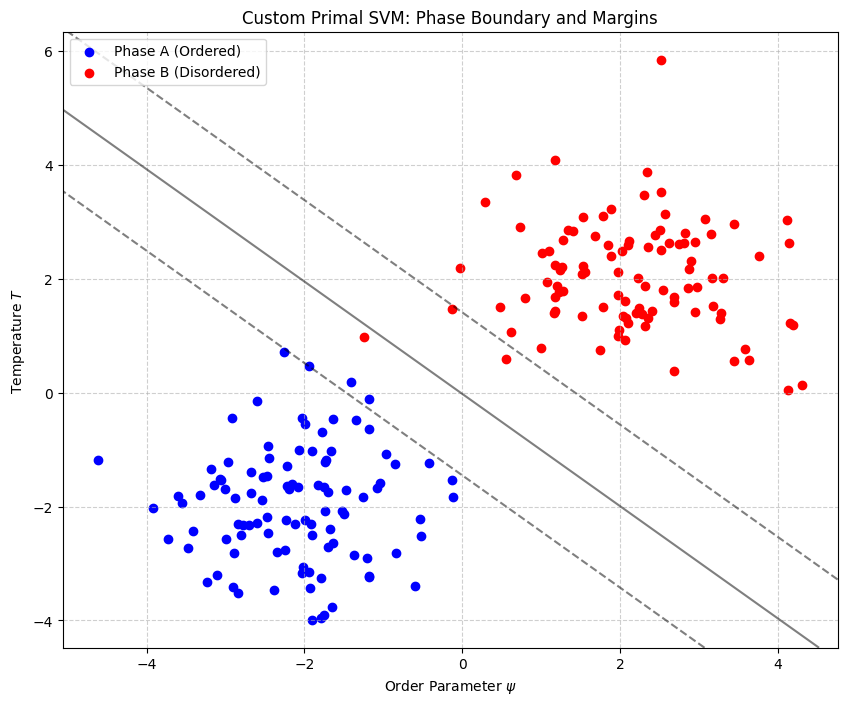

In [ ]:
class SVMPhysics:
    """
    Support Vector Machine implementation using Primal Optimization (Hinge Loss).
    Physics analogy: Minimizing 'energy' (norm of w) subject to 'constraint forces' (margin penalties).
    """
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param  # Regularization strength (1/C)
        self.n_iterations = n_iterations
        self.w = None
        self.b = None
        self.losses = []

    def fit(self, X, y):
        """
        X: (n_samples, n_features)
        y: (n_samples,) with values +1 or -1
        """
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        # Gradient Descent on Primal Objective (Hinge Loss):
        # J(w, b) = (lambda/2)||w||^2 + (1/N) * sum_i max(0, 1 - y_i (w·x_i + b))
        for _ in range(self.n_iterations):
            margins = y * (np.dot(X, self.w) + self.b)
            misclassified_idx = np.where(margins < 1)[0]

            dw = self.lambda_param * self.w
            db = 0.0

            for idx in misclassified_idx:
                dw -= (1.0 / n_samples) * y[idx] * X[idx]
                db -= (1.0 / n_samples) * y[idx]

            self.w -= self.lr * dw
            self.b -= self.lr * db

            hinge_loss = np.mean(np.maximum(0, 1 - margins))
            reg_loss = 0.5 * self.lambda_param * np.dot(self.w, self.w)
            self.losses.append(hinge_loss + reg_loss)

    def predict(self, X):
        linear_output = np.dot(X, self.w) + self.b
        return np.sign(linear_output)

# ---- 3. Train and visualize custom SVM ----
svm_custom = SVMPhysics(learning_rate=0.01, lambda_param=0.01, n_iterations=2000)
svm_custom.fit(X, y)

print("Custom SVM (primal GD):")
print(f"Weights w: {svm_custom.w}")
print(f"Bias b: {svm_custom.b}")

plt.figure(figsize=(10, 8))

plt.scatter(X[y==-1][:,0], X[y==-1][:,1], color='blue', label='Phase A (Ordered)')
plt.scatter(X[y==1][:,0], X[y==1][:,1], color='red', label='Phase B (Disordered)')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = (np.dot(xy, svm_custom.w) + svm_custom.b).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1],
           alpha=0.5, linestyles=['--', '-', '--'])

plt.title("Custom Primal SVM: Phase Boundary and Margins")
plt.xlabel(r"Order Parameter $\psi$")
plt.ylabel(r"Temperature $T$")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
